#Segmentation in keras and pytorch
Semantic segmentation is a fundamental task within computer vision which entails assigning class labels to individual pixels in an image

In this notebook we will look at how to build and train a [U-Net style metwork](https://arxiv.org/abs/1505.04597) for segmentation of pets in images from the [Oxford-IIT Pet dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/)


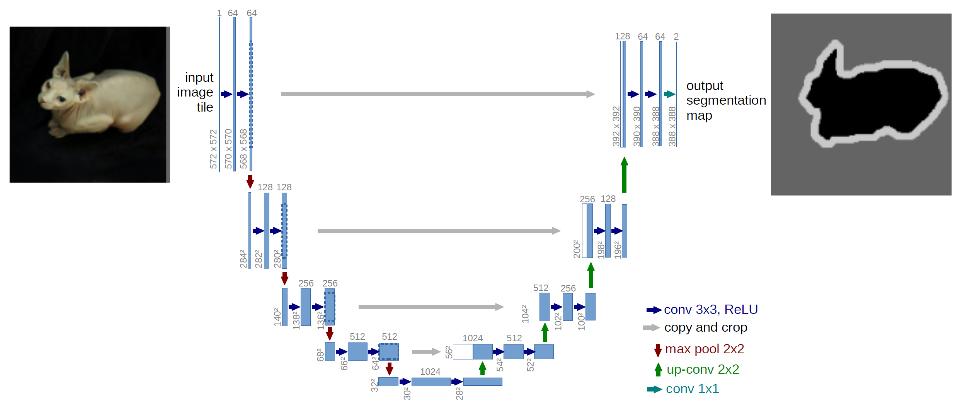

#The Unet
The Unet architecture is a deep learning model originally proposed for segmentation of biomedical images for segmentation of biomedical images. The model succes derives from et ability to learn from relatively little data due to its ability to process images at different resolutions, which for instance makes it possible to train it on image tiles (of patches), meaning high resolution images can be broken down into smaller parts and used to train the network, and take advantage of the large amount of signals represented by each individual pixel in an image, rather than the overall feature composition.

The name (u-net) derives from the structure of the network which consists of an encoder branch that downsamples the input, ekstracting local, low level features, and a decoder branch which upsamples the encoded feature representation and extracts global, high level features. The encoder and decoder is connected through skip connection,combining local and global features to provide context awarness in the model at each level of resolution in the two branches.
The final layer of the model is typically an 1x1 sigmoid neuron or n-way softmax that classifies individual pixels as belonging to one of the unique classes in the dataset.

The Architecture is relatively simpel, using only the building blocks from standard CNNs (convolutions, pooling, activations) and sometimes normalizations, only difference beeing the way they are arranged (as per the description above), and simple additions such as upsampling, "up-convolution" or unpooling, which is basically the reverse of the standard operations.

Due to its simplicity, the u-net i still a popular choice for many segmentation problems. But the architechture also allows for adding complexity without changing to overall sturcture (encoder-decoder u-shape) of the model. For instance, is i common to use a pretrained encoder (backbone), which is simply a classification model pretrained on some dataset (e.g. imagenet).  



##Implementing u-net using the Keras functional API

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model

# Define the U-Net architecture using the Functional API
def unet(input_shape=(256, 256, 3), num_classes=1):
    # Input layer
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottom layer
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Decoder
    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = concatenate([up5, conv3], axis=-1)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = concatenate([up6, conv2], axis=-1)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = concatenate([up7, conv1], axis=-1)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)

    # Output layer
    output = Conv2D(num_classes, 1, activation='sigmoid',padding = 'same')(conv7)

    # Create the model
    model = Model(inputs=inputs, outputs=output)

    return model

# Create a U-Net model with input shape (256, 256, 3) and one output channel
model = unet(input_shape=(256, 256, 3), num_classes=1)

# Compile the model (you can choose an appropriate optimizer and loss function for your task)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

del model #clean up memory

#Implemting U-net using the Pytorch nn module

In [ ]:
import torch
import torch.nn as nn
from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class encoder_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(encoder_block, self).__init__()

        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self,x):
      x = self.block(x)
      return x

class decoder_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(decoder_block, self).__init__()
        self.block = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )


    def forward(self,x):
        x = self.block(x)
        return x

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()


        self.e1 = encoder_block(in_channels,64)
        self.e2 = encoder_block(64,128)
        self.e3 = encoder_block(128,256)
        self.e4 = encoder_block(256,512)



        self.d1 = decoder_block(512,256)
        self.d2 = decoder_block(512,128)
        self.d3 = decoder_block(256,64)

        self.seg_block = nn.Sequential(nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(128,64,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,out_channels,kernel_size=1),
            nn.ReLu())


    def forward(self, x):
        # Encode
        x1 = self.e1(x)
        x2 = self.e2(x1)
        x3 = self.e3(x2)
        x4 = self.e4(x3)

        #decode
        x5 = self.d1(x4)

        x5 = torch.cat([x5,x3],1)

        x6 = self.d2(x5)

        x6 = torch.cat([x6,x2],1)

        x7 = self.d3(x6)

        x7 = torch.cat([x7,x1],1)

        x7 = self.seg_block(x7)


        return x7

# Create a U-Net model with 3 input channels and 1 output channel
model = UNet(in_channels=3, out_channels=1)

if torch.cuda.is_available():
    model.cuda()
# Print the model summary
#
print(summary(model,(3,256,256),1))

del model #clean up memory


#Training a Keras model

First let's set up imports of the dependencies.


In [ ]:
import tensorflow as tf
from tensorflow import keras

import random
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt


#Configuration

We are gonna train the models using these configurations and hyperparams. So, 160x160x3 rgb input images and we have three classes in out dataset. (Pet, border and background). Training the model for five epoch with a batch size of 16.

In [ ]:

# Image Config
HEIGHT = 160
WIDTH = 160
CHANNELS = 3
NUM_CLASSES = 3

# Training Config
BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 1e-4



#Download the data

We download the Oxford-IIT Pet dataset with TensorFlow Datasets (TFDS) with one line of code. Combine the training and test data, and then split the combined data into 80% training dataset and 20% test dataset (used later on for both validation and testing). We import the dataset for the tensorflow_datasets module, but convert it to numpy format so we can work with in pytorch aswell.

In [ ]:
import tensorflow_datasets as tfds
orig_train_ds, orig_val_ds = tfds.load(
    name="oxford_iiit_pet",
    split=["train+test[:80%]", "test[80%:]"],
)

orig_train_ds = tfds.as_numpy(orig_train_ds)
orig_val_ds = tfds.as_numpy(orig_val_ds)



#Preprocess the data

Here we processes the images and segmentation masks in the inputs dictionary, mapping the image pixel intensities from [0, 255] to the range [0.0, 1.0] and adjusting segmentation masks indices from 1-based to 0-based. Convert each image an mask from the tfds dataset to a numpy array and add them to list for training and validation image and mask lists, respectively.

In [ ]:
import tensorflow as tf

def unpackage_and_preprocess_inputs(ds):
    images = []
    segmentation_masks = []
    for i in ds:
        image = tf.cast(tf.image.resize(i['image'],(HEIGHT,WIDTH),method='area'), dtype=tf.float32) / 255.0 # images are resized, cast to float and scaled to 0-1 values
        images.append(image.numpy())
        mask = tf.cast(tf.image.resize(i["segmentation_mask"] - 1,(HEIGHT,WIDTH),method='nearest'),dtype = tf.float32) #masks are resized,  cast to values 0 to n classes-1
        segmentation_masks.append(mask.numpy())

    return images, segmentation_masks

train_images, train_masks = unpackage_and_preprocess_inputs(orig_train_ds)
val_images, val_masks = unpackage_and_preprocess_inputs(orig_val_ds)

del orig_train_ds #clean memory
del orig_val_ds #clean memory

In [ ]:
print('train images: ',len(train_images),type(train_images[0]),train_images[0].shape,train_images[0].dtype,np.min(train_images[0]),np.max(train_images[0]))


print('train masks: ',len(train_masks),type(train_masks[0]),train_masks[0].shape,train_masks[0].dtype,np.min(train_masks[0]),np.max(train_masks[0]))

print('val images: ',len(val_images),type(val_images[0]),val_images[0].shape,val_images[0].dtype,np.min(val_images[0]),np.max(val_images[0]))


print('val masks: ',len(val_masks),type(val_masks[0]),val_masks[0].shape,val_masks[0].dtype,np.min(val_masks[0]),np.max(val_masks[0]))


#Visualize data
Let's visualize a few images and their segmentation masks from the training data.

In [ ]:
import matplotlib.pyplot as plt
import random


fig = plt.figure(figsize=(10, 10))

columns = 2
rows = 5
for i in range(1, (columns*rows)+1):
    fig.add_subplot(rows, columns, i)
    im = train_images[i-1]
    lbl = (train_masks[i-1]*100)/255
    im = np.concatenate([im,np.dstack([lbl]*3)],axis=1)
    plt.axis('off')
    plt.imshow(im)


plt.show()




#Model architecture

The U-Net consists of an encoder for downsampling and a decoder for upsampling with skip connections.

The model architecture shapes like the letter U hence the name U-Net.

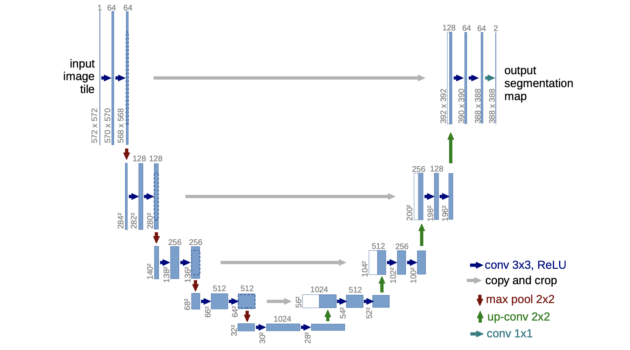

We reuse the code for implementation of a functional keras model presented above.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model




# Define the U-Net architecture using the Functional API
def unet(input_shape=(HEIGHT, WIDTH, CHANNELS), num_classes=3):
    # Input layer
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottom layer
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Decoder
    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = concatenate([up5, conv3], axis=-1)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = concatenate([up6, conv2], axis=-1)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = concatenate([up7, conv1], axis=-1)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)

    # Output layer
    output = Conv2D(num_classes, 3, activation='softmax',padding='same')(conv7)

    # Create the model
    model = Model(inputs=inputs, outputs=output)

    return model


We define a function which can show outputs (segmentations) from our model after each epoch. We use this to monitor the model training progress: visually inspect the images, predicted masks and ground truth masks besides the loss and accuracy metrics.

In [ ]:


def plot_epoch_results(test_images, test_masks,prediction,epoch):


    # Randomly select an image from the test batch
    random_index = random.randint(0, BATCH_SIZE - 1)
    random_image = test_images[random_index]
    random_pred_mask = ((pred_masks[random_index].astype(np.float32)/2)*100)/255
    #random_pred_mask = ((pred_masks[random_index].numpy().astype(np.float32)/2)*100)/255
    random_true_mask = (test_masks[random_index].astype(np.float32)*100)/255
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
    ax[0].imshow(random_image)
    ax[0].set_title(f"Image: {epoch:03d}")

    ax[1].imshow((random_true_mask*100)/255,cmap='gray')
    ax[1].set_title(f"Ground Truth Mask: {epoch:03d}")

    ax[2].imshow((random_pred_mask*100)/255,cmap='gray')
    ax[2].set_title(f"Predicted Mask: {epoch:03d}")

    plt.show()
    plt.close()



#Train the model

Now let's create the model, compile and train it for 5 epochs by. Rather than calling model fit(), we manually iterate over the data, extraction batch size images and labels in each interation and perform a single training step. For validation we do the same, except for training the model, we do a prediction/test on the vaidation data.

We do this to get rid of the datagenerators which are otherwise used when calling model fit, to make it a bit more verbose, and clear what is actually happening. This makes training a bit slower, but easier to debug.



In [ ]:
# Build model
model = unet(input_shape=(HEIGHT, WIDTH, CHANNELS), num_classes=NUM_CLASSES)


model.compile(
    optimizer=keras.optimizers.Adam(LEARNING_RATE),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()




To speed up training, go change the notebooks settings to use GPU hardware acceleration. You may need to run specific relevant cells of the notebook again after changing the accelartor.

In [ ]:
from tqdm import tqdm


###some stuff to make tensorflow act right when training on GPU
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass
tf.config.run_functions_eagerly(True)

for epoch in range(EPOCHS):
    model.reset_metrics()
    print(f'Epoch {epoch + 1} of {EPOCHS}')
    for batch in tqdm(range(0,len(train_images)//BATCH_SIZE)):
        train_im_batch = np.array(train_images[batch*BATCH_SIZE:batch*BATCH_SIZE+BATCH_SIZE]) #select batch_size images from the list of images we created and convert into a numpy array
        train_mask_batch = tf.keras.utils.to_categorical(np.array(train_masks[batch*BATCH_SIZE:batch*BATCH_SIZE+BATCH_SIZE]),num_classes=3) #select batch_size labels(ground truth annotations) and convert them to a one-hot encoded arrays with shape WIDTHxHEIGHTxCLASSES

        train_metrics = model.train_on_batch(train_im_batch,train_mask_batch,reset_metrics=False,return_dict=True) #train the model for a single iteration and return the metrics in a dictionary format. By setting "reset_metrics" to false, the dict will average values across all batches

    for metric in model.metrics_names:
        print(f'Train {metric}: {train_metrics[metric]}') # print the train metrics for this epoch

    model.reset_metrics() # reset the metrics so that they are only calculated for validation data in the next loop
    for batch in tqdm(range(0,len(val_images)//BATCH_SIZE)):
        val_im_batch = np.array(val_images[batch*BATCH_SIZE:batch*BATCH_SIZE+BATCH_SIZE])
        val_mask_batch = tf.keras.utils.to_categorical(np.array(val_masks[batch*BATCH_SIZE:batch*BATCH_SIZE+BATCH_SIZE]),num_classes=3)

        val_metrics = model.test_on_batch(val_im_batch,val_mask_batch,reset_metrics=False,return_dict=True)

    for metric in model.metrics_names:
        print(f'Validation {metric}: {val_metrics[metric]}')

    pred_masks = model.predict(np.array(val_images[batch*BATCH_SIZE:batch*BATCH_SIZE+BATCH_SIZE]))
    pred_masks = tf.math.argmax(pred_masks, axis=-1).numpy()

    plot_epoch_results(val_im_batch,np.array(val_masks[batch*BATCH_SIZE:batch*BATCH_SIZE+BATCH_SIZE]),pred_masks,epoch+1) #show an example segmentation




In [ ]:
from numba import cuda
#we run this code to clear the gpu memorory as colab is sometimes a bit weird with this
try:
  cuda.select_device(0) # choosing second GPU
  cuda.close()
except:
  pass

#Training a Pytorch model

Import modules

In [ ]:
import torch
import numpy as np
from torchvision import transforms
from PIL import Image
import torchvision


Show some example images and labels (same as for the tensorflow model)

In [ ]:
import matplotlib.pyplot as plt
import random


fig = plt.figure(figsize=(10, 10))

columns = 2
rows = 5
for i in range(1, (columns*rows)+1):
    fig.add_subplot(rows, columns, i)
    im = train_images[i-1]
    lbl = (train_masks[i-1]*100)/255
    im = np.concatenate([im,np.dstack([lbl]*3)],axis=1)
    plt.axis('off')
    plt.imshow(im)


plt.show()

Define model

In [ ]:
import torch.nn as nn
from torchsummary import summary


class encoder_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(encoder_block, self).__init__()

        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self,x):
      x = self.block(x)
      return x

class decoder_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(decoder_block, self).__init__()
        self.block = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )


    def forward(self,x):
        x = self.block(x)
        return x

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()


        self.e1 = encoder_block(in_channels,64)
        self.e2 = encoder_block(64,128)
        self.e3 = encoder_block(128,256)
        self.e4 = encoder_block(256,512)



        self.d1 = decoder_block(512,256)
        self.d2 = decoder_block(512,128)
        self.d3 = decoder_block(256,64)

        self.seg_block = nn.Sequential(nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(128,64,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,out_channels,kernel_size=1),
            nn.ReLU())



    def forward(self, x):
        # Encode
        x1 = self.e1(x)
        x2 = self.e2(x1)
        x3 = self.e3(x2)
        x4 = self.e4(x3)

        #decode
        x5 = self.d1(x4)

        x5 = torch.cat((x5,x3),1)

        x6 = self.d2(x5)

        x6 = torch.cat((x6,x2),1)

        x7 = self.d3(x6)

        x7 = torch.cat((x7,x1),1)

        out = self.seg_block(x7)


        return out

# Create a U-Net model with 3 input channels and 3 output channels
model = UNet(in_channels=CHANNELS, out_channels=NUM_CLASSES)

if torch.cuda.is_available():
    model.cuda()

#Print the model summary


print(summary(model,(CHANNELS,HEIGHT,WIDTH),BATCH_SIZE))




Train the model in a similar fashion to how the keras model was trained

In [ ]:

from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.to(device)

# Training Config
BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 1e-4

criterion = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE)

for epoch in range(EPOCHS):
    model.train()
    print(f'Epoch {epoch + 1} of {EPOCHS}')
    running_loss = 0
    running_accuracy = 0
    for batch in tqdm(range(0,len(train_images)//BATCH_SIZE)):

        train_im_batch = np.array(train_images[batch*BATCH_SIZE:batch*BATCH_SIZE+BATCH_SIZE])
        train_mask_batch = np.array(train_masks[batch*BATCH_SIZE:batch*BATCH_SIZE+BATCH_SIZE])

        train_im_batch = np.moveaxis(train_im_batch, -1, 1)
        train_mask_batch = np.moveaxis(train_mask_batch, -1, 1)

        train_im_batch = torch.from_numpy(train_im_batch)
        train_mask_batch = torch.from_numpy(train_mask_batch)


        optimizer.zero_grad()
        inputs = train_im_batch.to(device)
        targets = train_mask_batch.to(device)
        outputs = model(inputs)

        targets = targets.squeeze(dim=1)

        loss = criterion(outputs, targets.to(torch.int64))

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        acc = torch.sum(torch.argmax(nn.Softmax(dim = 1)(outputs),dim=1) == targets)/targets.nelement()
        running_accuracy += acc.item()




    print(f'Training loss: {running_loss/(len(train_images)//BATCH_SIZE)}')
    print(f'Training accuracy: {running_accuracy/(len(train_images)//BATCH_SIZE)}')


    running_loss = 0
    running_accuracy = 0
    model.eval()

    with torch.no_grad():
       for batch in tqdm(range(0,len(val_images)//BATCH_SIZE)):

        val_im_batch = np.array(val_images[batch*BATCH_SIZE:batch*BATCH_SIZE+BATCH_SIZE])
        val_mask_batch = np.array(val_masks[batch*BATCH_SIZE:batch*BATCH_SIZE+BATCH_SIZE])

        val_im_batch = np.moveaxis(val_im_batch, -1, 1)
        val_mask_batch = np.moveaxis(val_mask_batch, -1, 1)

        val_im_batch = torch.from_numpy(val_im_batch)
        val_mask_batch = torch.from_numpy(val_mask_batch)

        inputs = val_im_batch.to(device)
        targets = val_mask_batch.to(device)
        outputs = model(inputs)

        targets = targets.squeeze(dim=1)


        loss = criterion(outputs, targets.to(torch.int64))

        running_loss += loss.item()

        acc = torch.sum(torch.argmax(nn.Softmax(dim = 1)(outputs),dim=1) == targets)/targets.nelement()
        running_accuracy += acc.item()

    print(f'Validation loss: {running_loss/(len(val_images)//BATCH_SIZE)}')
    print(f'Validation accuracy: {running_accuracy/(len(val_images)//BATCH_SIZE)}')

    pred = nn.Softmax(dim = 1)(outputs)

    pred = pred.detach().cpu()


    pred_masks = np.argmax(np.moveaxis(pred.numpy(),1,-1),axis=-1)

    plot_epoch_results(np.array(val_images[batch*BATCH_SIZE:batch*BATCH_SIZE+BATCH_SIZE]),np.array(val_masks[batch*BATCH_SIZE:batch*BATCH_SIZE+BATCH_SIZE]),pred_masks,epoch+1)





#[Link for finding medical segmentation datasets for use in assignment 3]((https://paperswithcode.com/datasets?mod=medical&task=semantic-segmentation))